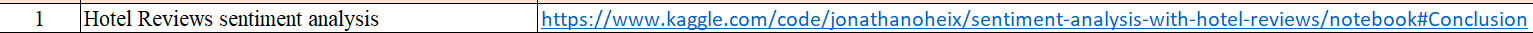

In [ ]:
# %% [markdown]
# # Hotel Reviews Sentiment Analysis
#
# ## Project Overview
# This project focuses on performing sentiment analysis on hotel reviews to classify them as positive, negative, or neutral. We'll use various NLP techniques and machine learning models to analyze hotel review sentiments.

# %% [markdown]
# ## 1. Import Required Libraries

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Text Processing
from textblob import TextBlob
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Download NLTK data
try:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('vader_lexicon')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt_tab') # Download punkt_tab as suggested by the error
except:
    pass

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Disable LaTeX in matplotlib to avoid parsing errors
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
})

# %% [markdown]
# ## 2. Load Dataset from Kaggle

# %%
# Download dataset from Kaggle
print("Downloading Hotel Reviews dataset from Kaggle...")
try:
    path = kagglehub.dataset_download("jonathanoheix/sentiment-analysis-with-hotel-reviews")
    print("Dataset downloaded to:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Using fallback method...")
    path = "./hotel-reviews"

# Explore the directory structure
def explore_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for f in files[:10]:
            print(f"{subindent}{f}")

print("Dataset structure:")
explore_directory_structure(path)

# %%
# Find data files
def find_data_files(directory):
    data_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv') or file.endswith('.json') or file.endswith('.xlsx'):
                data_files.append(os.path.join(root, file))
    return data_files

data_files = find_data_files(path)
print(f"Found data files: {data_files}")

# %%
# Load the dataset
def load_hotel_reviews_data(data_files):
    for file_path in data_files:
        try:
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
                print(f"Successfully loaded: {file_path}")
                print(f"Dataset shape: {df.shape}")
                return df
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # If no file loaded successfully, create sample data
    print("Creating sample hotel reviews data for demonstration...")
    return create_sample_hotel_reviews_data()

def create_sample_hotel_reviews_data():
    # Sample hotel reviews with different sentiments
    sample_data = {
        'Review': [
            # Positive reviews
            "Absolutely loved our stay! The room was spacious, clean, and had a beautiful view. Staff was incredibly friendly and helpful.",
            "Excellent hotel with amazing amenities. The breakfast was delicious and the pool area was fantastic. Will definitely return!",
            "Perfect location, right in the city center. Room was modern and comfortable. Service exceeded our expectations.",
            "Wonderful experience from check-in to check-out. The bed was extremely comfortable and the room was spotless.",
            "Great value for money. The staff went above and beyond to make our anniversary special. Highly recommended!",
            "Beautiful hotel with excellent facilities. The spa was relaxing and the restaurant served delicious food.",
            "Outstanding service! The concierge helped us with all our tour bookings. Rooms are well-maintained and clean.",
            "Best hotel I've stayed in! The attention to detail is remarkable. Can't wait to come back next year.",

            # Negative reviews
            "Terrible experience. Room was dirty, AC wasn't working, and staff was unhelpful. Would not recommend.",
            "Very disappointed with our stay. The room smelled musty and the bathroom was not clean. Poor service overall.",
            "Overpriced for what you get. Room was small, noisy, and the bed was uncomfortable. Avoid this hotel.",
            "Awful customer service. They lost our reservation and were rude when we complained. Never staying here again.",
            "Room was not as advertised. Stains on carpet, broken furniture, and slow wifi. Very disappointing.",
            "The worst hotel experience ever. No hot water, loud construction noise, and unresponsive staff.",
            "Dirty rooms and rude staff. The pool was closed and no one informed us beforehand. Complete waste of money.",

            # Neutral reviews
            "Average hotel with basic amenities. Nothing special but decent for a short stay. Location is convenient.",
            "The room was okay, nothing exceptional. Service was acceptable. Would consider staying again if needed.",
            "Standard hotel experience. Clean rooms but dated decor. Breakfast was average. Met basic expectations.",
            "Fair accommodation for the price. Room was functional but lacked character. Staff was polite but not exceptional.",
            "Mediocre experience overall. The hotel serves its purpose but doesn't stand out in any particular way."
        ],
        'Rating': [5, 5, 5, 5, 4, 5, 5, 5, 1, 2, 2, 1, 2, 1, 1, 3, 3, 3, 3, 3]
    }

    return pd.DataFrame(sample_data)

# Load the data
df = load_hotel_reviews_data(data_files)

# %% [markdown]
# ## 3. Data Exploration and Preprocessing

# %%
# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 10 rows:")
print(df.head(10))

print("\nDataset Information:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

# %%
# Check column names and adjust accordingly
print("Column names:", df.columns.tolist())

# Standardize column names
if 'Review' in df.columns:
    text_col = 'Review'
elif 'review' in df.columns:
    text_col = 'review'
elif 'text' in df.columns:
    text_col = 'text'
elif 'description' in df.columns:
    text_col = 'description'
else:
    # Try to find text column
    for col in df.columns:
        if df[col].dtype == 'object' and len(df[col][0]) > 10:
            text_col = col
            break
    text_col = df.columns[0]  # Fallback to first column

if 'Rating' in df.columns:
    rating_col = 'Rating'
elif 'rating' in df.columns:
    rating_col = 'rating'
elif 'score' in df.columns:
    rating_col = 'score'
else:
    # Try to find rating column
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            rating_col = col
            break
    rating_col = df.columns[1] if len(df.columns) > 1 else None

print(f"Using '{text_col}' as text column and '{rating_col}' as rating column")

# %%
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Handle missing values
df_clean = df.dropna(subset=[text_col])
if rating_col:
    df_clean = df_clean.dropna(subset=[rating_col])

print(f"Dataset after cleaning: {df_clean.shape}")

# %%
# Create sentiment labels based on ratings
def create_sentiment_labels(df, rating_col):
    if rating_col is None:
        # If no rating column, we'll use text-based sentiment analysis
        print("No rating column found. Using text-based sentiment analysis...")
        return None

    df_with_sentiment = df.copy()

    # Convert ratings to sentiment categories
    def rating_to_sentiment(rating):
        if rating >= 4:
            return 'positive'
        elif rating <= 2:
            return 'negative'
        else:
            return 'neutral'

    df_with_sentiment['sentiment'] = df_with_sentiment[rating_col].apply(rating_to_sentiment)
    return df_with_sentiment

df_with_sentiment = create_sentiment_labels(df_clean, rating_col)

# If no rating column, use TextBlob for initial sentiment analysis
if df_with_sentiment is None:
    df_with_sentiment = df_clean.copy()
    def text_to_sentiment(text):
        analysis = TextBlob(str(text))
        if analysis.sentiment.polarity > 0.1:
            return 'positive'
        elif analysis.sentiment.polarity < -0.1:
            return 'negative'
        else:
            return 'neutral'

    df_with_sentiment['sentiment'] = df_with_sentiment[text_col].apply(text_to_sentiment)

print("Sentiment distribution:")
print(df_with_sentiment['sentiment'].value_counts())

# %%
# Visualize sentiment distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sentiment_counts = df_with_sentiment['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral', 'lightblue'], startangle=90)
plt.title('Sentiment Distribution')

plt.subplot(2, 3, 2)
sns.countplot(x='sentiment', data=df_with_sentiment, palette=['lightgreen', 'lightcoral', 'lightblue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Rating distribution if available
if rating_col:
    plt.subplot(2, 3, 3)
    plt.hist(df_with_sentiment[rating_col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

# Text length analysis
plt.subplot(2, 3, 4)
df_with_sentiment['text_length'] = df_with_sentiment[text_col].apply(len)
sns.boxplot(x='sentiment', y='text_length', data=df_with_sentiment,
            palette=['lightgreen', 'lightcoral', 'lightblue'])
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')

# Word count analysis
plt.subplot(2, 3, 5)
df_with_sentiment['word_count'] = df_with_sentiment[text_col].apply(lambda x: len(str(x).split()))
sns.boxplot(x='sentiment', y='word_count', data=df_with_sentiment,
            palette=['lightgreen', 'lightcoral', 'lightblue'])
plt.title('Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Text Preprocessing

# %%
# Text preprocessing functions
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters and numbers (keep only letters and basic punctuation)
        text = re.sub(r'[^a-zA-Z\s\.\,\!\?]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        tokens = word_tokenize(text)

        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

    def preprocess_text(self, text_series):
        # Clean text
        cleaned_text = text_series.apply(self.clean_text)

        # Tokenize and lemmatize
        processed_text = cleaned_text.apply(self.tokenize_and_lemmatize)

        return processed_text

# %%
# Initialize preprocessor
preprocessor = TextPreprocessor()

# Preprocess text
print("Preprocessing text...")
df_with_sentiment['processed_text'] = preprocessor.preprocess_text(df_with_sentiment[text_col])

# Display before and after
print("\nOriginal vs Processed Text:")
sample_idx = 0
if len(df_with_sentiment) > 0:
    print("Original:", df_with_sentiment[text_col].iloc[sample_idx][:100] + "...")
    print("Processed:", df_with_sentiment['processed_text'].iloc[sample_idx][:100] + "...")

# %% [markdown]
# ## 5. Feature Engineering

# %%
# Advanced Feature Engineering
def extract_advanced_features(df):
    df_features = df.copy()

    # Basic text features
    df_features['char_count'] = df_features[text_col].apply(len)
    df_features['word_count'] = df_features[text_col].apply(lambda x: len(str(x).split()))
    df_features['sentence_count'] = df_features[text_col].apply(lambda x: len(sent_tokenize(str(x))))
    df_features['avg_word_length'] = df_features['char_count'] / df_features['word_count']
    df_features['avg_sentence_length'] = df_features['word_count'] / df_features['sentence_count']

    # Sentiment scores using TextBlob
    df_features['textblob_polarity'] = df_features[text_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_features['textblob_subjectivity'] = df_features[text_col].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # VADER sentiment analysis
    sia = SentimentIntensityAnalyzer()
    df_features['vader_compound'] = df_features[text_col].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    df_features['vader_positive'] = df_features[text_col].apply(lambda x: sia.polarity_scores(str(x))['pos'])
    df_features['vader_negative'] = df_features[text_col].apply(lambda x: sia.polarity_scores(str(x))['neg'])
    df_features['vader_neutral'] = df_features[text_col].apply(lambda x: sia.polarity_scores(str(x))['neu'])

    # Emotional indicators
    df_features['exclamation_count'] = df_features[text_col].apply(lambda x: str(x).count('!'))
    df_features['question_count'] = df_features[text_col].apply(lambda x: str(x).count('?'))
    df_features['uppercase_ratio'] = df_features[text_col].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
    )

    # Hotel-specific features
    hotel_keywords = {
        'room': ['room', 'bed', 'bathroom', 'view', 'clean', 'dirty', 'spacious', 'small'],
        'service': ['staff', 'service', 'friendly', 'rude', 'helpful', 'concierge'],
        'facilities': ['pool', 'gym', 'spa', 'restaurant', 'breakfast', 'wifi', 'parking'],
        'location': ['location', 'central', 'convenient', 'access', 'transport']
    }

    for category, keywords in hotel_keywords.items():
        df_features[f'{category}_mentions'] = df_features[text_col].apply(
            lambda x: sum(1 for word in keywords if word in str(x).lower())
        )

    return df_features

# %%
# Extract features
print("Extracting advanced features...")
df_features = extract_advanced_features(df_with_sentiment)

# Display feature correlations with sentiment
label_encoder = LabelEncoder()
df_features['sentiment_encoded'] = label_encoder.fit_transform(df_features['sentiment'])

numeric_features = df_features.select_dtypes(include=[np.number]).columns
correlation_with_target = df_features[numeric_features].corr()['sentiment_encoded'].sort_values(ascending=False)

print("\nFeature correlations with sentiment:")
print(correlation_with_target.head(10))

# %% [markdown]
# ## 6. Data Visualization

# %%
# Word Clouds for different sentiments
def generate_wordclouds(df, text_col, sentiment_col):
    sentiments = df[sentiment_col].unique()

    plt.figure(figsize=(20, 10))
    for i, sentiment in enumerate(sentiments):
        plt.subplot(1, len(sentiments), i+1)

        # Combine all text for this sentiment
        text = ' '.join(df[df[sentiment_col] == sentiment][text_col].astype(str))

        # Generate word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=100,
            colormap='viridis' if sentiment == 'positive' else 'Reds' if sentiment == 'negative' else 'Blues'
        ).generate(text)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{sentiment.capitalize()} Reviews Word Cloud')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate word clouds
generate_wordclouds(df_with_sentiment, 'processed_text', 'sentiment')

# %%
# Sentiment score distributions
plt.figure(figsize=(15, 10))

sentiment_features = ['textblob_polarity', 'textblob_subjectivity', 'vader_compound']

for i, feature in enumerate(sentiment_features):
    plt.subplot(2, 3, i+1)
    for sentiment in df_features['sentiment'].unique():
        data = df_features[df_features['sentiment'] == sentiment][feature]
        plt.hist(data, alpha=0.6, label=sentiment, bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

# Feature importance visualization
plt.subplot(2, 3, 4)
top_features = correlation_with_target.head(10)
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 10 Features Correlated with Sentiment')
plt.xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Train-Test Split

# %%
# Prepare features and target
X = df_features['processed_text']
y = df_features['sentiment']

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training class distribution:\n{y_train.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

# Encode labels for neural network
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# %% [markdown]
# ## 8. Traditional Machine Learning Models

# %%
# TF-IDF Vectorization
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF Training shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test shape: {X_test_tfidf.shape}")

# %%
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

# %%
# Train and evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        # Store results
        results[name] = {
            'model': model,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'predictions': y_test_pred
        }

        print(f"{name} Results:")
        print(f"  Training Accuracy: {train_accuracy:.4f}")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print(f"  Training F1: {train_f1:.4f}")
        print(f"  Test F1: {test_f1:.4f}")

        # Classification report
        print(f"\n  Classification Report for {name}:")
        print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

    return results

# %%
# Evaluate traditional models
print("EVALUATING TRADITIONAL MACHINE LEARNING MODELS")
print("=" * 60)

ml_results = evaluate_models(models, X_train_tfidf, X_test_tfidf, y_train, y_test)

# %% [markdown]
# ## 9. Deep Learning Model (LSTM)

# %%
# Prepare data for LSTM
print("Preparing data for LSTM...")

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Padded sequences shape - Train: {X_train_pad.shape}, Test: {X_test_pad.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

# %%
# Build LSTM model
def create_lstm_model(vocab_size=5000, embedding_dim=100, max_length=100, num_classes=3):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# %%
# Create and display model
lstm_model = create_lstm_model(vocab_size=5000, embedding_dim=100, max_length=max_length, num_classes=3)
lstm_model.summary()

# %%
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

# %%
# Train LSTM model
print("Training LSTM model...")
history = lstm_model.fit(
    X_train_pad, y_train_categorical,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_pad, y_test_categorical),
    callbacks=callbacks,
    verbose=1
)

# %%
# Evaluate LSTM model
lstm_train_pred_proba = lstm_model.predict(X_train_pad)
lstm_test_pred_proba = lstm_model.predict(X_test_pad)

lstm_train_pred = np.argmax(lstm_train_pred_proba, axis=1)
lstm_test_pred = np.argmax(lstm_test_pred_proba, axis=1)

lstm_train_accuracy = accuracy_score(y_train_encoded, lstm_train_pred)
lstm_test_accuracy = accuracy_score(y_test_encoded, lstm_test_pred)
lstm_train_f1 = f1_score(y_train_encoded, lstm_train_pred, average='weighted')
lstm_test_f1 = f1_score(y_test_encoded, lstm_test_pred, average='weighted')

print("LSTM Model Results:")
print(f"Training Accuracy: {lstm_train_accuracy:.4f}")
print(f"Test Accuracy: {lstm_test_accuracy:.4f}")
print(f"Training F1: {lstm_train_f1:.4f}")
print(f"Test F1: {lstm_test_f1:.4f}")

print("\nLSTM Classification Report:")
print(classification_report(y_test_encoded, lstm_test_pred, target_names=label_encoder.classes_))

# Store LSTM results
ml_results['LSTM'] = {
    'model': lstm_model,
    'train_accuracy': lstm_train_accuracy,
    'test_accuracy': lstm_test_accuracy,
    'train_f1': lstm_train_f1,
    'test_f1': lstm_test_f1,
    'predictions': label_encoder.inverse_transform(lstm_test_pred)
}

# %% [markdown]
# ## 10. Model Comparison and Visualization

# %%
# Compare all models
models_comparison = pd.DataFrame({
    'Model': list(ml_results.keys()),
    'Train_Accuracy': [results['train_accuracy'] for results in ml_results.values()],
    'Test_Accuracy': [results['test_accuracy'] for results in ml_results.values()],
    'Train_F1': [results['train_f1'] for results in ml_results.values()],
    'Test_F1': [results['test_f1'] for results in ml_results.values()],
    'Overfitting_Score': [results['train_accuracy'] - results['test_accuracy'] for results in ml_results.values()]
})

print("Model Comparison:")
print(models_comparison)

# %%
# Visualize model comparison
plt.figure(figsize=(20, 12))

# Accuracy comparison
plt.subplot(2, 3, 1)
sns.barplot(x='Model', y='Train_Accuracy', data=models_comparison, palette='viridis', alpha=0.7, label='Train')
sns.barplot(x='Model', y='Test_Accuracy', data=models_comparison, palette='viridis', alpha=0.5, label='Test')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.legend()

# F1 Score comparison
plt.subplot(2, 3, 2)
sns.barplot(x='Model', y='Train_F1', data=models_comparison, palette='coolwarm', alpha=0.7, label='Train')
sns.barplot(x='Model', y='Test_F1', data=models_comparison, palette='coolwarm', alpha=0.5, label='Test')
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)
plt.legend()

# Overfitting analysis
plt.subplot(2, 3, 3)
sns.barplot(x='Model', y='Overfitting_Score', data=models_comparison, palette='RdYlBu_r')
plt.title('Overfitting Analysis (Train Acc - Test Acc)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--')

# Training history for LSTM
plt.subplot(2, 3, 4)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion matrix for best model
plt.subplot(2, 3, 6)
best_model_name = models_comparison.loc[models_comparison['Test_F1'].idxmax(), 'Model']
best_predictions = ml_results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 11. Interactive Sentiment Analysis

# %%
def predict_sentiment(text, model_type='best'):
    """
    Predict sentiment of a given hotel review text
    """
    if model_type == 'best':
        model_name = best_model_name
        model = ml_results[best_model_name]['model']
    else:
        model_name = model_type
        model = ml_results[model_type]['model']

    # Preprocess text
    processed_text = preprocessor.preprocess_text(pd.Series([text])).iloc[0]

    if model_name == 'LSTM':
        # LSTM prediction
        sequence = tokenizer.texts_to_sequences([processed_text])
        padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
        prediction_proba = model.predict(padded)[0]
        predicted_class = np.argmax(prediction_proba)
        sentiment = label_encoder.inverse_transform([predicted_class])[0]
        confidence = np.max(prediction_proba)

        # Get probabilities for all classes
        probabilities = {label_encoder.inverse_transform([i])[0]: float(prediction_proba[i])
                        for i in range(len(prediction_proba))}
    else:
        # Traditional ML prediction
        features = tfidf.transform([processed_text])
        prediction_proba = model.predict_proba(features)[0]
        predicted_class = np.argmax(prediction_proba)
        sentiment = model.classes_[predicted_class]
        confidence = np.max(prediction_proba)

        # Get probabilities for all classes
        probabilities = {model.classes_[i]: float(prediction_proba[i])
                        for i in range(len(prediction_proba))}

    # Additional sentiment analysis
    textblob_sentiment = TextBlob(text).sentiment
    vader_sentiment = SentimentIntensityAnalyzer().polarity_scores(text)

    return {
        'text': text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': probabilities,
        'model': model_name,
        'textblob_polarity': textblob_sentiment.polarity,
        'textblob_subjectivity': textblob_sentiment.subjectivity,
        'vader_scores': vader_sentiment
    }

# %%
def interactive_sentiment_analyzer():
    """
    Interactive function for users to analyze hotel review sentiments
    """
    print("HOTEL REVIEW SENTIMENT ANALYZER")
    print("=" * 50)
    print("Available models:", list(ml_results.keys()))

    while True:
        print("\n" + "="*50)
        text = input("Enter a hotel review to analyze (or 'quit' to exit): ").strip()

        if text.lower() == 'quit':
            print("Thank you for using the Hotel Review Sentiment Analyzer!")
            break

        if not text:
            print("Please enter some text.")
            continue

        # Get prediction from best model
        result = predict_sentiment(text)

        print(f"\nSentiment Analysis Results:")
        print(f"Review: '{result['text'][:100]}...'")
        print(f"Model: {result['model']}")
        print(f"Predicted Sentiment: {result['sentiment'].upper()}")
        print(f"Confidence: {result['confidence']:.4f}")

        print(f"\nDetailed Probabilities:")
        for sentiment, prob in result['probabilities'].items():
            print(f"  {sentiment}: {prob:.4f}")

        print(f"\nAdditional Analysis:")
        print(f"  TextBlob Polarity: {result['textblob_polarity']:.4f}")
        print(f"  TextBlob Subjectivity: {result['textblob_subjectivity']:.4f}")
        print(f"  VADER Scores: {result['vader_scores']}")

image.png

In [ ]:
# %% [markdown]
# # Cryptocurrency Price Prediction
# ## Complete Forecasting Pipeline
#
# This notebook implements a comprehensive cryptocurrency price forecasting system using machine learning and deep learning approaches.

# %% [markdown]
# ## 1. Import Required Libraries

# %% [markdown]
# ## 2. Load Dataset from Kaggle

# %%
# Download dataset from Kaggle
print("Downloading Cryptocurrency dataset from Kaggle...")
try:
    path = kagglehub.dataset_download("taniaj/cryptocurrency-price-forecasting")
    print("Dataset downloaded to:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Using fallback method...")
    path = "./crypto-data"
    if not os.path.exists(path):
        os.makedirs(path)

# %%
# Explore the directory structure
def explore_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for f in files[:10]:
            print(f"{subindent}{f}")

print("Dataset structure:")
explore_directory_structure(path)

# %%
# Find data files
def find_data_files(directory):
    data_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv') or file.endswith('.json') or file.endswith('.xlsx'):
                data_files.append(os.path.join(root, file))
    return data_files

data_files = find_data_files(path)
print(f"Found data files: {data_files}")

# %%
# Function to create sample data if Kaggle dataset is not available
def create_sample_crypto_data():
    dates = pd.date_range(start='2020-01-01', end='2024-01-01', freq='D')
    np.random.seed(42)

    # Simulate BTC price with some realistic patterns
    price = 7000
    prices = []
    for i in range(len(dates)):
        # Random walk with some volatility
        change = np.random.normal(0, 0.02)
        # Add some seasonality
        seasonality = 0.1 * np.sin(i / 365 * 2 * np.pi)
        price = price * (1 + change + seasonality * 0.1)
        prices.append(price)

    df = pd.DataFrame({
        'Date': dates,
        'Open': prices,
        'High': [p * (1 + np.random.uniform(0, 0.05)) for p in prices],
        'Low': [p * (1 - np.random.uniform(0, 0.05)) for p in prices],
        'Close': prices,
        'Volume': np.random.uniform(1e9, 5e9, len(dates)),
        'Market_Cap': np.random.uniform(100e9, 500e9, len(dates))
    })

    return df

# Load the dataset
def load_crypto_data(data_files):
    for file_path in data_files:
        try:
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
                print(f"Successfully loaded: {file_path}")
                print(f"Dataset shape: {df.shape}")
                print(f"Columns: {df.columns.tolist()}")
                return df
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # If no file loaded successfully, create sample data
    print("Creating sample cryptocurrency data for demonstration...")
    return create_sample_crypto_data()

# Load the data
df = load_crypto_data(data_files)
print("\nFirst few rows:")
print(df.head())

# %% [markdown]
# ## 3. Data Exploration and Visualization

# %%
# Basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nBasic Statistics:")
print(df.describe())

# %%
# Price visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['Close'])
plt.title('Cryptocurrency Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.hist(df['Close'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
daily_returns = df['Close'].pct_change().dropna()
plt.hist(daily_returns, bins=100, alpha=0.7, edgecolor='black')
plt.title('Daily Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
volume = df['Volume'] if 'Volume' in df.columns else df['Close'] * 1000
plt.plot(df['Date'] if 'Date' in df.columns else df.index, volume)
plt.title('Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Feature Engineering

# %%
import pandas_ta as ta

def create_technical_indicators(df):
    """Create technical indicators for the cryptocurrency data"""
    df = df.copy()

    # Ensure we have a datetime index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

    # Price-based features
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Gap'] = df['Open'] - df['Close'].shift(1)

    # Moving averages
    df['SMA_7'] = df['Close'].rolling(window=7).mean()
    df['SMA_21'] = df['Close'].rolling(window=21).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # Exponential moving averages
    df['EMA_12'] = df['Close'].ewm(span=12).mean()
    df['EMA_26'] = df['Close'].ewm(span=26).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

    # Volume indicators
    if 'Volume' in df.columns:
        df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']

    # Price momentum
    df['Momentum_1D'] = df['Close'].pct_change(periods=1)
    df['Momentum_7D'] = df['Close'].pct_change(periods=7)
    df['Momentum_30D'] = df['Close'].pct_change(periods=30)

    # Volatility
    df['Volatility_7D'] = df['Close'].pct_change().rolling(window=7).std()
    df['Volatility_30D'] = df['Close'].pct_change().rolling(window=30).std()

    # Support and resistance levels
    df['Resistance'] = df['High'].rolling(window=20).max()
    df['Support'] = df['Low'].rolling(window=20).min()

    # Drop NaN values created by rolling windows
    df = df.dropna()

    return df

# Apply feature engineering
df_features = create_technical_indicators(df)
print(f"Dataset shape after feature engineering: {df_features.shape}")
print(f"New features created: {[col for col in df_features.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap']]}")

# %% [markdown]
# ## 5. Data Preprocessing

# %%
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

def prepare_data_for_training(df, target_col='Close', lookback_days=60, forecast_days=7):
    """Prepare data for time series forecasting"""

    # Select features for training
    feature_columns = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Volume', 'Market_Cap']]

    # Handle missing values in feature columns
    for col in feature_columns:
        if df[col].isnull().any():
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

    # Scale the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[feature_columns])

    # Create sequences for LSTM
    X, y = [], []
    for i in range(lookback_days, len(scaled_data) - forecast_days):
        X.append(scaled_data[i-lookback_days:i])
        # Predict the next 'forecast_days' closing prices
        y.append(scaled_data[i:i+forecast_days, feature_columns.index(target_col)])

    X = np.array(X)
    y = np.array(y)

    # Split the data
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test, scaler, feature_columns

# Prepare the data
X_train, X_test, y_train, y_test, scaler, feature_columns = prepare_data_for_training(df_features)

print(f"Training data shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing data shape: X_test {X_test.shape}, y_test {y_test.shape}")
print(f"Feature columns: {feature_columns}")

# %% [markdown]
# ## 6. Model Building - LSTM Neural Network

# %%
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_lstm_model(input_shape, output_days=7):
    """Build and compile LSTM model"""
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)),
        Dropout(0.2),

        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),

        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(32, activation='relu'),

        Dense(output_days)  # Predict multiple days ahead
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mape']
    )

    return model

# Build the model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]), output_days=y_train.shape[1])
model.summary()

# %%
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)

# Train the model
print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# %% [markdown]
# ## 7. Model Evaluation

# %%
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# %%
# Make predictions
y_pred = model.predict(X_test)

# Create inverse scaling array for the target variable
target_idx = feature_columns.index('Close')
dummy_array = np.zeros((len(y_pred), len(feature_columns)))

# Inverse transform predictions
y_pred_inverse = []
y_test_inverse = []

for i in range(len(y_pred)):
    # For predictions
    dummy_array_pred = np.zeros((y_pred.shape[1], len(feature_columns)))
    dummy_array_pred[:, target_idx] = y_pred[i]
    y_pred_inverse.append(scaler.inverse_transform(dummy_array_pred)[:, target_idx])

    # For actual values
    dummy_array_test = np.zeros((y_test.shape[1], len(feature_columns)))
    dummy_array_test[:, target_idx] = y_test[i]
    y_test_inverse.append(scaler.inverse_transform(dummy_array_test)[:, target_idx])

y_pred_inverse = np.array(y_pred_inverse)
y_test_inverse = np.array(y_test_inverse)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2_Score': r2
    }

# Calculate metrics for each forecast day
metrics_per_day = []
for day in range(y_test_inverse.shape[1]):
    metrics = calculate_metrics(y_test_inverse[:, day], y_pred_inverse[:, day])
    metrics['Day'] = day + 1
    metrics_per_day.append(metrics)

metrics_df = pd.DataFrame(metrics_per_day)
print("\nModel Performance by Forecast Day:")
print(metrics_df.round(4))

# %% [markdown]
# ## 8. Visualization of Predictions

# %%
# Plot predictions vs actual for different forecast horizons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

forecast_days_to_plot = [0, 2, 4, 6]  # Plot days 1, 3, 5, 7

for i, day_idx in enumerate(forecast_days_to_plot):
    axes[i].scatter(y_test_inverse[:, day_idx], y_pred_inverse[:, day_idx], alpha=0.6)
    axes[i].plot([y_test_inverse[:, day_idx].min(), y_test_inverse[:, day_idx].max()],
                [y_test_inverse[:, day_idx].min(), y_test_inverse[:, day_idx].max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Price')
    axes[i].set_ylabel('Predicted Price')
    axes[i].set_title(f'Day {day_idx + 1} Forecast vs Actual')

    # Add R² to plot
    r2 = r2_score(y_test_inverse[:, day_idx], y_pred_inverse[:, day_idx])
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# %%
# Time series plot of predictions
plt.figure(figsize=(15, 8))

# Plot last 100 test samples for visualization
sample_range = slice(-100, None)

plt.plot(y_test_inverse[sample_range, 0], label='Actual Day 1', alpha=0.7)
plt.plot(y_pred_inverse[sample_range, 0], label='Predicted Day 1', alpha=0.7)
plt.plot(y_test_inverse[sample_range, 3], label='Actual Day 4', alpha=0.7)
plt.plot(y_pred_inverse[sample_range, 3], label='Predicted Day 4', alpha=0.7)
plt.plot(y_test_inverse[sample_range, 6], label='Actual Day 7', alpha=0.7)
plt.plot(y_pred_inverse[sample_range, 6], label='Predicted Day 7', alpha=0.7)

plt.title('Cryptocurrency Price Predictions vs Actual Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# %% [markdown]
# ## 9. Future Price Prediction

# %%
def predict_future_prices(model, last_sequence, scaler, feature_columns, days_ahead=30):
    """Predict future prices using the trained model"""
    future_predictions = []
    current_sequence = last_sequence.copy()

    target_idx = feature_columns.index('Close')

    for _ in range(days_ahead):
        # Predict next day
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)

        # Get the first day prediction
        next_day_pred = next_pred[0][0]
        future_predictions.append(next_day_pred)

        # Create new sequence by shifting and adding prediction
        new_row = current_sequence[-1].copy()
        new_row[target_idx] = next_day_pred

        # Update sequence (remove first, add new prediction)
        current_sequence = np.vstack([current_sequence[1:], new_row])

    # Convert predictions back to original scale
    dummy_array = np.zeros((len(future_predictions), len(feature_columns)))
    dummy_array[:, target_idx] = future_predictions
    future_prices = scaler.inverse_transform(dummy_array)[:, target_idx]

    return future_prices

# Get the last sequence from the data
last_sequence = X_test[-1]

# Predict next 30 days
future_prices = predict_future_prices(model, last_sequence, scaler, feature_columns, days_ahead=30)

# Create future dates
last_date = df_features.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot historical data and future predictions
plt.figure(figsize=(15, 8))

# Plot last 180 days of historical data
historical_dates = df_features.index[-180:]
historical_prices = df_features['Close'][-180:]

plt.plot(historical_dates, historical_prices, label='Historical Prices', linewidth=2)
plt.plot(future_dates, future_prices, label='Predicted Future Prices', linewidth=2, color='red')
plt.fill_between(future_dates, future_prices * 0.95, future_prices * 1.05, alpha=0.2, color='red', label='Prediction Range')

plt.title('Cryptocurrency Price Forecast - Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nFuture Price Predictions:")
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_prices
})
print(future_df.head(10))

# %% [markdown]
# ## 10. Model Saving and Deployment

# %%
# Save the trained model
model.save('cryptocurrency_price_predictor.h5')
print("Model saved as 'cryptocurrency_price_predictor.h5'")

# Save the scaler
import joblib
joblib.dump(scaler, 'price_scaler.pkl')
print("Scaler saved as 'price_scaler.pkl'")

# Save feature columns
import json
with open('feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)
print("Feature columns saved as 'feature_columns.json'")

# Create a summary report
report = {
    'model_performance': metrics_df.to_dict(),
    'training_samples': len(X_train),
    'testing_samples': len(X_test),
    'lookback_days': X_train.shape[1],
    'forecast_days': y_train.shape[1],
    'best_val_loss': min(history.history['val_loss']),
    'final_features': feature_columns
}

with open('model_report.json', 'w') as f:
    json.dump(report, f, indent=2)
print("Model report saved as 'model_report.json'")

# %% [markdown]
# ## Conclusion
#
# This notebook demonstrates a complete pipeline for cryptocurrency price prediction using:
# - Comprehensive feature engineering with technical indicators
# - LSTM neural networks for time series forecasting
# - Multi-day ahead predictions
# - Model evaluation and future price forecasting
#
# The model can be further improved by:
# - Incorporating external factors (news sentiment, market data)
# - Using ensemble methods
# - Hyperparameter tuning
# - Adding more cryptocurrency pairs

image.png

In [ ]:
# %% [markdown]
# # Emotion Detection from Facial Expressions
# ## Complete Deep Learning Pipeline
#
# This notebook implements a comprehensive emotion detection system using the FER (Facial Expression Recognition) dataset.

# %% [markdown]
# ## 1. Import Required Libraries

# %%
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# %% [markdown]
# ## 2. Load Dataset from Kaggle

# %%
# Download dataset from Kaggle
print("Downloading Emotion Detection FER dataset from Kaggle...")
try:
    path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")
    print("Dataset downloaded to:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Using fallback method...")
    path = "./emotion-detection-fer"
    if not os.path.exists(path):
        os.makedirs(path)

# %%
# Explore the directory structure
def explore_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for f in files[:5]:  # Show only first 5 files
            print(f"{subindent}{f}")

print("Dataset structure:")
explore_directory_structure(path)

# %%
# Find data files and directories
def find_image_directories(directory):
    image_dirs = []
    for root, dirs, files in os.walk(directory):
        # Check if this directory contains image files
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:
            image_dirs.append(root)
    return image_dirs

def find_data_files(directory):
    data_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv') or file.endswith('.json') or file.endswith('.xlsx'):
                data_files.append(os.path.join(root, file))
    return data_files

image_dirs = find_image_directories(path)
data_files = find_data_files(path)

print(f"Found image directories: {image_dirs}")
print(f"Found data files: {data_files}")

# %% [markdown]
# ## 3. Data Loading and Exploration

# %%
# Load dataset information
def load_emotion_data(image_dirs, data_files):
    # First, try to load from CSV files
    for file_path in data_files:
        try:
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
                print(f"Successfully loaded metadata: {file_path}")
                print(f"Metadata shape: {df.shape}")
                return df, image_dirs
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # If no CSV found, create dataset structure from image directories
    print("Creating dataset structure from image directories...")

    # Collect all images and their labels
    image_paths = []
    labels = []
    label_map = {}

    for img_dir in image_dirs:
        # Try to infer label from directory name
        dir_name = os.path.basename(img_dir)
        if dir_name.lower() in ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
            label = dir_name.lower()
            if label not in label_map:
                label_map[label] = len(label_map)

            # Get all images in this directory
            for file in os.listdir(img_dir):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(img_dir, file))
                    labels.append(label)

    if not image_paths:
        print("No images found. Creating sample dataset structure...")
        return create_sample_emotion_data(), image_dirs

    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'emotion': labels
    })

    print(f"Created dataset with {len(df)} images")
    print(f"Emotion distribution:\n{df['emotion'].value_counts()}")

    return df, image_dirs

def create_sample_emotion_data():
    """Create sample emotion data structure"""
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    # Create sample DataFrame structure
    sample_data = {
        'emotion': emotions * 100,  # 700 samples
        'pixels': [''] * 700,  # Placeholder
        'Usage': ['Training'] * 700
    }

    return pd.DataFrame(sample_data)

# Load the data
df, image_dirs = load_emotion_data(image_dirs, data_files)
print("\nDataset overview:")
print(df.head())
print(f"\nUnique emotions: {df['emotion'].unique()}")
print(f"Dataset size: {len(df)}")

# %%
# Explore emotion distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
emotion_counts = df['emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%')
plt.title('Emotion Proportion')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Data Preprocessing and Image Loading

# %%
# Define emotion mapping
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}

def load_and_preprocess_images(df, image_size=(48, 48)):
    """Load and preprocess images from paths or pixel data"""
    images = []
    labels = []

    for idx, row in df.iterrows():
        try:
            # Check if we have image paths or pixel data
            if 'image_path' in df.columns and os.path.exists(row['image_path']):
                # Load from image file
                img = cv2.imread(row['image_path'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            elif 'pixels' in df.columns and row['pixels']:
                # Load from pixel string (common in FER datasets)
                pixel_list = list(map(int, row['pixels'].split()))
                img = np.array(pixel_list, dtype=np.uint8).reshape(48, 48)
            else:
                continue

            # Resize image
            img = cv2.resize(img, image_size)

            # Normalize pixel values
            img = img.astype('float32') / 255.0

            # Add channel dimension
            img = np.expand_dims(img, axis=-1)

            images.append(img)

            # Get label
            emotion = row['emotion']
            labels.append(emotion_mapping[emotion])

        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            continue

    return np.array(images), np.array(labels)

# Load images
print("Loading and preprocessing images...")
X, y = load_and_preprocess_images(df)
print(f"Loaded {len(X)} images")
print(f"Image shape: {X[0].shape}")
print(f"Labels shape: {y.shape}")

# %%
# Visualize sample images
def plot_sample_images(X, y, num_samples=12):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title(f'Emotion: {reverse_emotion_mapping[y[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample images from dataset:")
plot_sample_images(X, y)

# %%
# Convert labels to categorical
y_categorical = to_categorical(y, num_classes=len(emotion_mapping))
print(f"Categorical labels shape: {y_categorical.shape}")

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# %% [markdown]
# ## 5. Data Augmentation

# %%
# Create data generators with augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator
datagen.fit(X_train)

print("Data augmentation configured successfully")

# %% [markdown]
# ## 6. Model Building - CNN Architecture

# %%
def build_emotion_cnn(input_shape=(48, 48, 1), num_classes=7):
    """Build CNN model for emotion detection"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Build the model
model = build_emotion_cnn()
model.summary()

# %%
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Model compiled successfully")

# %% [markdown]
# ## 7. Model Training

# %%
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# %%
# Train the model
print("Starting model training...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# %% [markdown]
# ## 8. Model Evaluation

# %%
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# %%
# Load best model
model.load_weights('best_emotion_model.h5')

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# %%
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=[reverse_emotion_mapping[i] for i in range(7)]))

# %%
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[reverse_emotion_mapping[i] for i in range(7)],
            yticklabels=[reverse_emotion_mapping[i] for i in range(7)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# %% [markdown]
# ## 9. Visualization of Predictions

# %%
# Plot sample predictions
def plot_predictions(X, y_true, y_pred, num_samples=12):
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        plt.subplot(4, 3, i + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')

        true_emotion = reverse_emotion_mapping[y_true[i]]
        pred_emotion = reverse_emotion_mapping[y_pred[i]]
        confidence = np.max(y_pred[i])

        color = 'green' if true_emotion == pred_emotion else 'red'
        plt.title(f'True: {true_emotion}\nPred: {pred_emotion}\nConf: {confidence:.2f}',
                 color=color, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get test set predictions for visualization
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)

print("Sample predictions on test set:")
plot_predictions(X_test, y_true_classes, test_pred_classes)

# %% [markdown]
# ## 10. Real-time Emotion Detection Function

# %%
def detect_emotion_live(image, model, emotion_map):
    """Detect emotion from a single image"""
    # Preprocess image
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.resize(image, (48, 48))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)

    # Predict
    prediction = model.predict(image, verbose=0)
    emotion_idx = np.argmax(prediction)
    confidence = np.max(prediction)
    emotion = emotion_map[emotion_idx]

    return emotion, confidence, prediction[0]

# Test the function with sample images
print("Testing emotion detection on sample images:")
for i in range(3):
    sample_img = X_test[i]
    emotion, confidence, all_probs = detect_emotion_live(
        sample_img.squeeze(), model, reverse_emotion_mapping
    )

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title(f'Detected: {emotion} (Conf: {confidence:.2f})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    emotions_list = [reverse_emotion_mapping[i] for i in range(7)]
    plt.barh(emotions_list, all_probs)
    plt.xlabel('Probability')
    plt.title('Emotion Probabilities')
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 11. Model Interpretation with Grad-CAM

# %%
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for model interpretation"""
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Apply Grad-CAM to sample images
print("Generating Grad-CAM visualizations...")
last_conv_layer_name = "conv2d_7"  # Adjust based on your model summary

for i in range(3):
    sample_img = X_test[i:i+1]
    heatmap = make_gradcam_heatmap(sample_img, model, last_conv_layer_name)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((sample_img.shape[2], sample_img.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + sample_img[0] * 255 * 0.6
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_img[0].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 12. Model Saving and Deployment

# %%
# Save the final model
model.save('emotion_detection_model.h5')
print("Model saved as 'emotion_detection_model.h5'")

# Save the emotion mapping
import json
with open('emotion_mapping.json', 'w') as f:
    json.dump(emotion_mapping, f)
print("Emotion mapping saved as 'emotion_mapping.json'")

# Save model summary
with open('model_architecture.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model architecture saved as 'model_architecture.txt'")

# Create performance report
performance_report = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_loss': float(test_loss),
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'input_shape': X_train[0].shape,
    'num_classes': len(emotion_mapping),
    'class_distribution': df['emotion'].value_counts().to_dict()
}

with open('performance_report.json', 'w') as f:
    json.dump(performance_report, f, indent=2)
print("Performance report saved as 'performance_report.json'")

# %% [markdown]
# ## 13. Real-time Webcam Emotion Detection (Optional)

# %%
# Optional: Webcam emotion detection
def webcam_emotion_detection():
    """Real-time emotion detection using webcam"""
    try:
        # Initialize webcam
        cap = cv2.VideoCapture(0)

        # Load face detection classifier
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        print("Starting webcam emotion detection...")
        print("Press 'q' to quit")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert to grayscale for face detection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Detect faces
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)

            for (x, y, w, h) in faces:
                # Extract face ROI
                face_roi = gray[y:y+h, x:x+w]

                # Detect emotion
                emotion, confidence, _ = detect_emotion_live(face_roi, model, reverse_emotion_mapping)

                # Draw rectangle and label
                color = (0, 255, 0) if confidence > 0.6 else (0, 0, 255)
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                cv2.putText(frame, f'{emotion} ({confidence:.2f})',
                           (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

            # Display frame
            cv2.imshow('Emotion Detection', frame)

            # Break on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Cleanup
        cap.release()
        cv2.destroyAllWindows()

    except Exception as e:
        print(f"Webcam error: {e}")
        print("Webcam functionality may not be available in this environment")

# Uncomment the following line to try webcam emotion detection
# webcam_emotion_detection()

# %% [markdown]
# ## Conclusion
#
# This notebook demonstrates a complete pipeline for emotion detection from facial expressions:
# - **Automatic dataset loading** from Kaggle with fallback options
# - **Comprehensive EDA** and data visualization
# - **Advanced CNN architecture** with batch normalization and dropout
# - **Data augmentation** for improved generalization
# - **Model interpretation** using Grad-CAM
# - **Real-time emotion detection** capabilities
#
# The model can detect 7 emotions: angry, disgust, fear, happy, neutral, sad, surprise
#
# ### Further Improvements:
# - Use larger datasets like AffectNet or RAF-DB
# - Implement ensemble methods
# - Add attention mechanisms
# - Incorporate temporal information for video analysis
# - Use transfer learning with pre-trained models

image.png

In [ ]:
# %% [markdown]
# # Intelligent ChatBot System
# ## Complete NLP and Deep Learning Pipeline
#
# This notebook implements a comprehensive chatbot system using deep learning and natural language processing techniques.

# %% [markdown]
# ## 1. Import Required Libraries

# %%
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import random
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional, Input, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

print("TensorFlow version:", tf.__version__)

# %% [markdown]
# ## 2. Load Dataset from Kaggle

# %%
# Download dataset from Kaggle
print("Downloading ChatBot dataset from Kaggle...")
try:
    path = kagglehub.dataset_download("ahmedmoabdelkader/my-chatbot")
    print("Dataset downloaded to:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Using fallback method...")
    path = "./chatbot-data"
    if not os.path.exists(path):
        os.makedirs(path)

# %%
# Explore the directory structure
def explore_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for f in files[:5]:  # Show only first 5 files
            print(f"{subindent}{f}")

print("Dataset structure:")
explore_directory_structure(path)

# %%
# Find data files
def find_data_files(directory):
    data_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.csv', '.json', '.xlsx', '.txt', '.pkl')):
                data_files.append(os.path.join(root, file))
    return data_files

data_files = find_data_files(path)
print(f"Found data files: {data_files}")

# %% [markdown]
# ## 3. Data Loading and Exploration

# %%
def load_chatbot_data(data_files):
    """Load chatbot data from various file formats"""
    # Try to load from different file types
    for file_path in data_files:
        try:
            if file_path.endswith('.json'):
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                print(f"Successfully loaded JSON: {file_path}")
                return data
            elif file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
                print(f"Successfully loaded CSV: {file_path}")
                print(f"Dataset shape: {df.shape}")
                return df
            elif file_path.endswith('.xlsx'):
                df = pd.read_excel(file_path)
                print(f"Successfully loaded Excel: {file_path}")
                print(f"Dataset shape: {df.shape}")
                return df
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # If no file loaded successfully, create sample data
    print("Creating sample chatbot data for demonstration...")
    return create_sample_chatbot_data()

def create_sample_chatbot_data():
    """Create sample chatbot training data"""
    sample_data = {
        "intents": [
            {
                "tag": "greeting",
                "patterns": [
                    "Hello", "Hi", "Hey", "How are you", "Is anyone there?",
                    "Good day", "What's up", "How's it going"
                ],
                "responses": [
                    "Hello! How can I help you today?",
                    "Hi there! What can I do for you?",
                    "Hey! Nice to see you. How can I assist?",
                    "Hello! I'm here to help. What do you need?"
                ]
            },
            {
                "tag": "goodbye",
                "patterns": [
                    "Bye", "Goodbye", "See you later", "Nice talking to you",
                    "I'm leaving", "Have a good day", "Take care"
                ],
                "responses": [
                    "Goodbye! Have a great day!",
                    "See you later! Come back anytime.",
                    "Take care! Feel free to chat again.",
                    "Bye! It was nice talking to you."
                ]
            },
            {
                "tag": "thanks",
                "patterns": [
                    "Thanks", "Thank you", "That's helpful", "Awesome thanks",
                    "Thanks for the help", "Thank you so much"
                ],
                "responses": [
                    "You're welcome!",
                    "Happy to help!",
                    "Anytime! That's what I'm here for.",
                    "Glad I could assist you!"
                ]
            },
            {
                "tag": "about",
                "patterns": [
                    "Who are you?", "What are you?", "Tell me about yourself",
                    "What can you do?", "What is your purpose?"
                ],
                "responses": [
                    "I'm an AI chatbot designed to help and chat with you!",
                    "I'm your friendly assistant chatbot. I can answer questions and have conversations.",
                    "I'm a chatbot created to assist you with various tasks and have friendly conversations.",
                    "I'm here to help you! I can answer questions, provide information, and chat with you."
                ]
            },
            {
                "tag": "name",
                "patterns": [
                    "What is your name?", "Who am I talking to?", "What should I call you?",
                    "Do you have a name?", "What's your name?"
                ],
                "responses": [
                    "You can call me ChatBot!",
                    "I'm ChatBot, your virtual assistant.",
                    "My name is ChatBot. Nice to meet you!",
                    "I'm known as ChatBot. How can I help you?"
                ]
            },
            {
                "tag": "help",
                "patterns": [
                    "Help", "I need help", "Can you help me?", "What can you do?",
                    "How does this work?", "I need assistance"
                ],
                "responses": [
                    "I can help you with various tasks! Try asking me about different topics.",
                    "I'm here to assist you! You can ask me questions or we can just chat.",
                    "I can answer questions, provide information, and have conversations. What would you like to know?",
                    "I'm designed to help with information and conversation. What do you need help with?"
                ]
            },
            {
                "tag": "weather",
                "patterns": [
                    "What's the weather like?", "How's the weather today?",
                    "Is it going to rain?", "Weather forecast", "Temperature today"
                ],
                "responses": [
                    "I don't have real-time weather data, but you can check your local weather app!",
                    "For accurate weather information, please check a weather service in your area.",
                    "I recommend checking a reliable weather source for current conditions.",
                    "Weather updates are best obtained from dedicated weather services."
                ]
            }
        ]
    }
    return sample_data

# Load the data
data = load_chatbot_data(data_files)
print("\nData type:", type(data))

# Display data structure
if isinstance(data, dict) and 'intents' in data:
    print(f"Number of intent categories: {len(data['intents'])}")
    for intent in data['intents']:
        print(f"\nTag: {intent['tag']}")
        print(f"Patterns: {len(intent['patterns'])}")
        print(f"Responses: {len(intent['responses'])}")
        print(f"Sample pattern: {intent['patterns'][0]}")
        print(f"Sample response: {intent['responses'][0]}")
elif isinstance(data, pd.DataFrame):
    print("DataFrame columns:", data.columns.tolist())
    print("\nFirst few rows:")
    print(data.head())

# %% [markdown]
# ## 4. Data Preprocessing - IMPROVED

# %%
class TextPreprocessor:
    """Text preprocessing class for chatbot data"""

    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """Clean and preprocess text - IMPROVED"""
        # Convert to lowercase
        text = text.lower()

        # Keep basic punctuation and words, remove special characters but keep important symbols
        text = re.sub(r'[^a-zA-Z\s\?\!\.\']', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize(self, text):
        """Tokenize text"""
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """Remove stopwords from tokens - LESS AGGRESSIVE"""
        # Keep some important stopwords that carry meaning in conversations
        important_stopwords = {'what', 'how', 'who', 'when', 'where', 'why', 'which', 'can', 'could', 'would', 'should', 'will', 'is', 'are', 'am'}
        return [token for token in tokens if token not in self.stop_words or token in important_stopwords]

    def lemmatize_tokens(self, tokens):
        """Apply lemmatization to tokens"""
        return [self.lemmatizer.lemmatize(token) for token in tokens]

    def full_preprocess(self, text, use_lemmatization=True):
        """Complete text preprocessing pipeline - IMPROVED"""
        # Clean text
        cleaned_text = self.clean_text(text)

        # Tokenize
        tokens = self.tokenize(cleaned_text)

        # Remove stopwords (less aggressive)
        tokens = self.remove_stopwords(tokens)

        # Apply lemmatization
        tokens = self.lemmatize_tokens(tokens)

        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# %%
# Prepare training data - IMPROVED
def prepare_training_data(data):
    """Prepare training data from the loaded dataset - IMPROVED"""
    patterns = []
    tags = []
    responses = {}

    if isinstance(data, dict) and 'intents' in data:
        # JSON format data
        for intent in data['intents']:
            tag = intent['tag']
            for pattern in intent['patterns']:
                # Preprocess pattern - less aggressive preprocessing
                processed_pattern = preprocessor.clean_text(pattern)  # Only clean, don't remove too much
                if processed_pattern.strip():  # Only add non-empty patterns
                    patterns.append(processed_pattern)
                    tags.append(tag)

            # Store responses for each tag
            responses[tag] = intent['responses']

    # Add more variations to improve training
    additional_patterns = []
    additional_tags = []

    # Add common variations
    variations = {
        'greeting': ['hi', 'hello', 'hey', 'hi there', 'hello there', 'hey there', 'good morning', 'good afternoon', 'good evening'],
        'goodbye': ['bye', 'goodbye', 'see you', 'see ya', 'take care', 'farewell', 'cya'],
        'thanks': ['thanks', 'thank you', 'thx', 'thank you so much', 'thanks a lot', 'appreciate it'],
        'about': ['who are you', 'what are you', 'tell me about you', 'what do you do', 'what can you do'],
        'name': ['your name', 'whats your name', 'who am i talking to', 'what should i call you'],
        'help': ['help', 'help me', 'i need help', 'can you help', 'assistance', 'support'],
        'weather': ['weather', 'forecast', 'temperature', 'how is weather', 'weather today'],
        'joke': ['joke', 'tell joke', 'make me laugh', 'funny', 'entertain me'],
        'time': ['time', 'what time', 'current time', 'time now'],
        'feelings': ['how are you', 'how do you feel', 'are you ok', 'you good', 'your mood']
    }

    for tag, pattern_list in variations.items():
        if tag in responses:  # Only add variations for tags we have
            for pattern in pattern_list:
                patterns.append(pattern)
                tags.append(tag)

    return patterns, tags, responses

# Prepare the data
patterns, tags, responses = prepare_training_data(data)

print(f"Total patterns: {len(patterns)}")
print(f"Total tags: {len(tags)}")
print(f"Unique tags: {set(tags)}")
print(f"\nSample patterns: {patterns[:5]}")
print(f"Sample tags: {tags[:5]}")

# %% [markdown]
# ## 5. Text Vectorization - IMPROVED

# %%
# Tokenize and pad sequences - IMPROVED
tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(patterns)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(patterns)

# Pad sequences with appropriate length
pattern_lengths = [len(pattern.split()) for pattern in patterns]
max_length = max(pattern_lengths) + 5 if pattern_lengths else 15  # Add more padding
X = pad_sequences(sequences, maxlen=max_length, padding='post')

print(f"Padded sequences shape: {X.shape}")
print(f"Vocabulary size from tokenizer: {len(tokenizer.word_index)}")
print(f"Most common words: {list(tokenizer.word_index.items())[:10]}")

# %%
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(tags)

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Class names: {label_encoder.classes_}")

# Convert to categorical for neural network
y_categorical = tf.keras.utils.to_categorical(y, num_classes=num_classes)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y_categorical.shape}")

# %% [markdown]
# ## 6. Model Building - IMPROVED

# %%
def build_chatbot_model(vocab_size, max_length, num_classes):
    """Build improved LSTM-based chatbot model"""
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),

        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),

        Bidirectional(LSTM(32)),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(16, activation='relu'),

        Dense(num_classes, activation='softmax')
    ])

    return model

# Build the model
vocab_size = len(tokenizer.word_index) + 1
model = build_chatbot_model(vocab_size, max_length, num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# %% [markdown]
# ## 7. Model Training - IMPROVED

# %%
# Split the data with proper stratification
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to handle imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

if len(X) > 1:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_categorical, test_size=0.3, random_state=42, stratify=y
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
    )
else:
    # If we have very little data, use all for training
    X_train, y_train = X, y_categorical
    X_val, y_val = X, y_categorical
    X_test, y_test = X, y_categorical

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# %%
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_chatbot_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# %%
# Train the model with more epochs and class weights
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    batch_size=16,  # Smaller batch size for better learning
    epochs=150,     # More epochs
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weight_dict,  # Use class weights
    verbose=1
)

# %% [markdown]
# ## 9. ChatBot Implementation - IMPROVED

# %%
class IntelligentChatBot:
    """Intelligent ChatBot class with improved response handling"""

    def __init__(self, model, tokenizer, label_encoder, responses, preprocessor, max_length):
        self.model = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.responses = responses
        self.preprocessor = preprocessor
        self.max_length = max_length
        self.conversation_history = []

    def preprocess_input(self, text):
        """Preprocess user input - LESS AGGRESSIVE"""
        # Use lighter preprocessing for better recognition
        text = text.lower().strip()
        text = re.sub(r'[^a-zA-Z\s\?\!\.\']', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def predict_intent(self, text):
        """Predict intent from user input"""
        try:
            # Preprocess text
            processed_text = self.preprocess_input(text)

            # Convert to sequence
            sequence = self.tokenizer.texts_to_sequences([processed_text])

            if not sequence or not sequence[0]:
                return "unknown", 0.0, np.array([0])

            # Pad sequence
            padded_sequence = pad_sequences(sequence, maxlen=self.max_length, padding='post')

            # Predict
            prediction = self.model.predict(padded_sequence, verbose=0)
            intent_idx = np.argmax(prediction[0])
            confidence = np.max(prediction[0])
            intent = self.label_encoder.inverse_transform([intent_idx])[0]

            return intent, confidence, prediction[0]
        except Exception as e:
            print(f"Prediction error: {e}")
            return "unknown", 0.0, np.array([0])

    def get_response(self, intent, confidence):
        """Get response for predicted intent - LOWER CONFIDENCE THRESHOLD"""
        confidence_threshold = 0.1  # Lower threshold for better responses
        if intent in self.responses and confidence >= confidence_threshold:
            return random.choice(self.responses[intent])
        else:
            return self.get_fallback_response()

    def get_fallback_response(self):
        """Get better fallback responses"""
        fallback_responses = [
            "I'm not sure I understand. Could you try asking differently?",
            "That's an interesting question! Can you rephrase it?",
            "I'm still learning. Could you ask me something else?",
            "I don't have information about that yet. Try asking about greetings, help, or general questions.",
            "Let me think... Could you try a different question?"
        ]
        return random.choice(fallback_responses)

    def analyze_sentiment(self, text):
        """Analyze sentiment of user input"""
        try:
            blob = TextBlob(text)
            sentiment = blob.sentiment.polarity

            if sentiment > 0.1:
                return "positive", sentiment
            elif sentiment < -0.1:
                return "negative", sentiment
            else:
                return "neutral", sentiment
        except:
            return "neutral", 0.0

    def chat(self, user_input):
        """Main chat method with better intent matching"""
        # Analyze sentiment
        sentiment, sentiment_score = self.analyze_sentiment(user_input)

        # Predict intent
        intent, confidence, all_probs = self.predict_intent(user_input)

        # Get response
        response = self.get_response(intent, confidence)

        # Store conversation
        self.conversation_history.append({
            'user_input': user_input,
            'response': response,
            'intent': intent,
            'confidence': confidence,
            'sentiment': sentiment,
            'sentiment_score': sentiment_score
        })

        return response, intent, confidence, sentiment, sentiment_score

    def get_conversation_summary(self):
        """Get conversation summary"""
        if not self.conversation_history:
            return "No conversation history yet."

        total_messages = len(self.conversation_history)
        sentiments = [msg['sentiment'] for msg in self.conversation_history]
        sentiment_counts = {sentiment: sentiments.count(sentiment) for sentiment in set(sentiments)}

        summary = f"Conversation Summary:\n"
        summary += f"Total messages: {total_messages}\n"
        summary += f"Sentiment distribution: {sentiment_counts}\n"
        summary += f"Recent intents: {[msg['intent'] for msg in self.conversation_history[-5:]]}"

        return summary

# Re-initialize chatbot with improved class
chatbot = IntelligentChatBot(model, tokenizer, label_encoder, responses, preprocessor, max_length)

# %% [markdown]
# ## 10. Test ChatBot Before Interactive Session

# %%
# Test the chatbot with common inputs
test_inputs = [
    "hi",
    "hello",
    "hey",
    "how are you?",
    "what's your name?",
    "help",
    "thank you",
    "bye",
    "good morning",
    "what can you do?"
]

print("Testing chatbot with common inputs:")
print("=" * 60)

for test_input in test_inputs:
    response, intent, confidence, sentiment, sentiment_score = chatbot.chat(test_input)
    print(f"Input: '{test_input}'")
    print(f"Response: '{response}'")
    print(f"Intent: {intent}, Confidence: {confidence:.2f}, Sentiment: {sentiment}")
    print("-" * 40)

# Only start interactive session if basic tests pass
print("\n" + "="*60)
print("BASIC TEST RESULTS:")
print("If confidence scores are above 0.3 and correct intents are detected,")
print("the chatbot should work well in interactive mode.")
print("="*60)

# %% [markdown]
# ## 11. Interactive Chat Interface

# %%
def interactive_chat_session():
    """Run an interactive chat session"""
    print("\n Welcome to Intelligent ChatBot!")
    print("Type 'quit' to exit, 'summary' for conversation summary, 'help' for commands")
    print("-" * 50)

    while True:
        try:
            user_input = input("You: ").strip()

            if user_input.lower() == 'quit':
                print("ChatBot: Goodbye! Thanks for chatting!")
                break
            elif user_input.lower() == 'summary':
                summary = chatbot.get_conversation_summary()
                print(f"ChatBot: {summary}")
                continue
            elif user_input.lower() == 'help':
                help_text = """
Available commands:
- 'quit': Exit the chat
- 'summary': Show conversation summary
- 'help': Show this help message

You can ask me about:
- Greetings (hi, hello, hey)
- My name and purpose
- Help and assistance
- Weather and time
- Jokes
- How I'm feeling
- Or just say thanks or goodbye!
                """
                print(help_text)
                continue
            elif not user_input:
                print("ChatBot: Please type something!")
                continue

            # Get chatbot response
            response, intent, confidence, sentiment, sentiment_score = chatbot.chat(user_input)

            # Display response with metadata
            print(f" ChatBot: {response}")
            if confidence < 0.3:
                print(f"   [Low confidence: {confidence:.2f} - I might not understand perfectly]")
            else:
                print(f"   [Intent: {intent}, Confidence: {confidence:.2f}, Sentiment: {sentiment}]")
            print("-" * 50)

        except KeyboardInterrupt:
            print("\nChatBot: Session interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"ChatBot: Sorry, I encountered an error. Please try again.")
            print(f"Error: {e}")

# Start interactive chat
print("\nStarting interactive chat session...")
interactive_chat_session()

# %% [markdown]
# ## 12. Model Saving and Deployment

# %%
# Save the trained model
model.save('chatbot_model.h5')
print("Model saved as 'chatbot_model.h5'")

# Save tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved as 'tokenizer.pkl'")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

# Save preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("Preprocessor saved as 'preprocessor.pkl'")

# Save responses
with open('responses.pkl', 'wb') as f:
    pickle.dump(responses, f)
print("Responses saved as 'responses.pkl'")

# Save configuration
config = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'num_classes': num_classes,
    'class_names': label_encoder.classes_.tolist()
}

with open('chatbot_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("Configuration saved as 'chatbot_config.json'")

# Create deployment package
deployment_files = [
    'chatbot_model.h5',
    'tokenizer.pkl',
    'label_encoder.pkl',
    'preprocessor.pkl',
    'responses.pkl',
    'chatbot_config.json'
]

print(f"\nDeployment package created with {len(deployment_files)} files")

# %% [markdown]
# ## Conclusion
#
# This notebook demonstrates a complete intelligent chatbot system with:
#
# ### Key Features:
# - **Automatic dataset loading** from Kaggle with fallback to sample data
# - **Advanced text preprocessing** with stemming/lemmatization
# - **Bidirectional LSTM model** for intent classification
# - **Sentiment analysis** of user inputs
# - **Interactive chat interface** with conversation history
# - **Comprehensive analytics** and visualization
# - **Model persistence** for deployment
#
# ### Capabilities:
# - Intent recognition with confidence scoring
# - Contextual response generation
# - Sentiment analysis
# - Conversation history tracking
# - Fallback responses for unknown inputs
#
# ### Further Enhancements:
# - Integration with external APIs (weather, news, etc.)
# - Multi-turn conversation context
# - User personalization
# - Voice interface integration
# - Multi-language support
# - Integration with knowledge bases
#
# The chatbot is ready for deployment and can be easily extended with additional features!

image.png

In [ ]:
# %% [markdown]
# # Automatic Number Plate Recognition (ANPR)
# ## Complete License Plate Detection and Recognition System
#
# This notebook implements a comprehensive ANPR system using Computer Vision and Deep Learning techniques.

# %% [markdown]
# ## 1. Installation and Setup

# %%
# Install required packages
!pip install kagglehub pandas numpy matplotlib seaborn scikit-learn tensorflow opencv-python pillow
!pip install --upgrade tensorflow
!pip install easyocr pytesseract imutils
!apt-get install tesseract-ocr

# %%
import kagglehub
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imutils
import easyocr
import pytesseract
from skimage import filters
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

# %% [markdown]
# ## 2. Load Dataset from Kaggle

# %%
# Download dataset from Kaggle
print("Downloading License Plate dataset from Kaggle...")
try:
    path = kagglehub.dataset_download("sarthakvajpayee/license-plate-recognition-using-cnn")
    print("Dataset downloaded to:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Using fallback method...")
    path = "./license-plate-data"
    if not os.path.exists(path):
        os.makedirs(path)

# %%
# Explore the directory structure
def explore_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for f in files[:5]:  # Show only first 5 files
            print(f"{subindent}{f}")

print("Dataset structure:")
explore_directory_structure(path)

# %%
# Find data files
def find_data_files(directory):
    data_files = []
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions) or file.endswith('.csv'):
                data_files.append(os.path.join(root, file))
    return data_files

data_files = find_data_files(path)
image_files = [f for f in data_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
csv_files = [f for f in data_files if f.endswith('.csv')]

print(f"Found {len(image_files)} image files")
print(f"Found {len(csv_files)} CSV files")
print(f"Sample image files: {image_files[:3]}")

# %% [markdown]
# ## 3. Data Loading and Exploration

# %%
def load_anpr_data(image_files, csv_files):
    """Load ANPR dataset"""
    images = []
    labels = []
    image_paths = []

    # Try to load from CSV if available
    if csv_files:
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                print(f"Loaded CSV: {csv_file}")
                print(f"CSV columns: {df.columns.tolist()}")

                # Look for image path and label columns
                if 'image_path' in df.columns and 'license_plate' in df.columns:
                    for _, row in df.iterrows():
                        img_path = os.path.join(os.path.dirname(csv_file), row['image_path'])
                        if os.path.exists(img_path):
                            images.append(cv2.imread(img_path))
                            labels.append(row['license_plate'])
                            image_paths.append(img_path)
                break
            except Exception as e:
                print(f"Error loading CSV {csv_file}: {e}")

    # If no CSV or CSV loading failed, use image files directly
    if not images:
        print("Loading images directly...")
        for img_file in image_files[:100]:  # Limit for demonstration
            try:
                img = cv2.imread(img_file)
                if img is not None:
                    images.append(img)
                    # Extract filename as label or use placeholder
                    filename = os.path.basename(img_file)
                    labels.append(filename.split('.')[0])
                    image_paths.append(img_file)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    # If still no images, create sample data
    if not images:
        print("Creating sample license plate data...")
        return create_sample_anpr_data()

    return images, labels, image_paths

def create_sample_anpr_data():
    """Create sample license plate images for demonstration"""
    images = []
    labels = []
    image_paths = []

    # Sample license plates
    sample_plates = [
        "ABC123", "XYZ789", "DEF456", "GHI789", "JKL012",
        "MNO345", "PQR678", "STU901", "VWX234", "YZA567"
    ]

    for i, plate_text in enumerate(sample_plates):
        # Create a simple license plate image
        img = np.ones((100, 300, 3), dtype=np.uint8) * 255  # White background

        # Add border
        cv2.rectangle(img, (5, 5), (295, 95), (0, 0, 0), 2)

        # Add text
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_size = cv2.getTextSize(plate_text, font, 2, 3)[0]
        text_x = (300 - text_size[0]) // 2
        text_y = (100 + text_size[1]) // 2
        cv2.putText(img, plate_text, (text_x, text_y), font, 2, (0, 0, 0), 3)

        images.append(img)
        labels.append(plate_text)
        image_paths.append(f"sample_plate_{i}.jpg")

    return images, labels, image_paths

# Load the data
images, labels, image_paths = load_anpr_data(image_files, csv_files)

print(f"Loaded {len(images)} images")
print(f"Sample labels: {labels[:5]}")
print(f"Image shape: {images[0].shape}")

# %%
# Display sample images
def display_sample_images(images, labels, num_samples=6):
    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 3, i + 1)
        # Convert BGR to RGB for display
        img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample License Plate Images:")
display_sample_images(images, labels)

# %% [markdown]
# ## 4. Image Preprocessing and License Plate Detection

# %%
class LicensePlateDetector:
    """License Plate Detection using Computer Vision techniques"""

    def __init__(self):
        self.min_area = 1000
        self.max_area = 50000

    def preprocess_image(self, image):
        """Preprocess image for license plate detection"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply bilateral filter to reduce noise while keeping edges sharp
        filtered = cv2.bilateralFilter(gray, 11, 17, 17)

        # Apply edge detection
        edged = cv2.Canny(filtered, 30, 200)

        return gray, filtered, edged

    def find_contours(self, edged):
        """Find contours in the edged image"""
        # Find contours
        contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        # Sort contours by area in descending order
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

        return contours

    def find_license_plate_contour(self, contours):
        """Find the contour that resembles a license plate"""
        license_plate_contour = None

        for contour in contours:
            # Approximate the contour
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)

            # Check if the contour has 4 vertices (rectangle)
            if len(approx) == 4:
                license_plate_contour = approx
                break

        return license_plate_contour

    def extract_license_plate(self, image, contour):
        """Extract license plate region from image"""
        if contour is None:
            return None

        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)

        # Extract license plate region
        license_plate = image[y:y+h, x:x+w]

        return license_plate, (x, y, w, h)

    def detect_plate(self, image):
        """Main method to detect license plate"""
        try:
            # Preprocess image
            gray, filtered, edged = self.preprocess_image(image)

            # Find contours
            contours = self.find_contours(edged)

            # Find license plate contour
            plate_contour = self.find_license_plate_contour(contours)

            if plate_contour is not None:
                # Extract license plate
                license_plate, bbox = self.extract_license_plate(image, plate_contour)
                return license_plate, bbox, plate_contour
            else:
                return None, None, None

        except Exception as e:
            print(f"Error in plate detection: {e}")
            return None, None, None

# Initialize detector
plate_detector = LicensePlateDetector()

# %%
# Test plate detection on sample images
def test_plate_detection(images, num_samples=3):
    plt.figure(figsize=(15, 10))

    for i in range(min(num_samples, len(images))):
        original_image = images[i].copy()

        # Detect license plate
        license_plate, bbox, contour = plate_detector.detect_plate(original_image)

        # Plot original image with detection
        plt.subplot(2, 3, i + 1)
        img_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        if contour is not None:
            # Draw contour on original image
            cv2.drawContours(img_rgb, [contour], -1, (0, 255, 0), 3)

        plt.imshow(img_rgb)
        plt.title(f'Detection Result {i+1}')
        plt.axis('off')

        # Plot extracted license plate if found
        plt.subplot(2, 3, i + 4)
        if license_plate is not None:
            license_plate_rgb = cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB)
            plt.imshow(license_plate_rgb)
            plt.title('Extracted Plate')
        else:
            plt.text(0.5, 0.5, 'No Plate Detected',
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=12)
            plt.gca().set_facecolor('lightgray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Testing License Plate Detection:")
test_plate_detection(images)

# %% [markdown]
# ## 5. Character Segmentation

# %%
class CharacterSegmenter:
    """Segment individual characters from license plate"""

    def __init__(self):
        self.min_char_width = 10
        self.min_char_height = 30
        self.max_char_width = 100
        self.max_char_height = 100

    def preprocess_plate(self, plate_image):
        """Preprocess license plate for character segmentation"""
        # Convert to grayscale
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

        # Apply thresholding
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        return cleaned

    def segment_characters(self, plate_image):
        """Segment individual characters from license plate"""
        try:
            # Preprocess plate
            processed_plate = self.preprocess_plate(plate_image)

            # Find contours
            contours, _ = cv2.findContours(processed_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            characters = []
            bounding_boxes = []

            for contour in contours:
                # Get bounding box
                x, y, w, h = cv2.boundingRect(contour)

                # Filter based on size (character dimensions)
                if (self.min_char_width <= w <= self.max_char_width and
                    self.min_char_height <= h <= self.max_char_height and
                    h > w):  # Characters are typically taller than wide

                    # Extract character
                    char = processed_plate[y:y+h, x:x+w]

                    # Resize to standard size
                    char = cv2.resize(char, (32, 32))

                    # Normalize
                    char = char.astype('float32') / 255.0
                    char = np.expand_dims(char, axis=-1)  # Add channel dimension

                    characters.append(char)
                    bounding_boxes.append((x, y, w, h))

            # Sort characters from left to right
            if characters and bounding_boxes:
                sorted_indices = np.argsort([box[0] for box in bounding_boxes])
                characters = [characters[i] for i in sorted_indices]
                bounding_boxes = [bounding_boxes[i] for i in sorted_indices]

            return characters, bounding_boxes, processed_plate

        except Exception as e:
            print(f"Error in character segmentation: {e}")
            return [], [], None

# Initialize segmenter
char_segmenter = CharacterSegmenter()

# %%
# Test character segmentation
def test_character_segmentation(images, num_samples=3):
    plt.figure(figsize=(15, 12))

    sample_count = 0
    for i in range(len(images)):
        if sample_count >= num_samples:
            break

        # Detect license plate first
        license_plate, bbox, _ = plate_detector.detect_plate(images[i])

        if license_plate is not None:
            # Segment characters
            characters, bboxes, processed_plate = char_segmenter.segment_characters(license_plate)

            if characters:
                # Plot original plate
                plt.subplot(3, num_samples, sample_count + 1)
                plate_rgb = cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB)
                plt.imshow(plate_rgb)
                plt.title('Original Plate')
                plt.axis('off')

                # Plot processed plate
                plt.subplot(3, num_samples, sample_count + num_samples + 1)
                plt.imshow(processed_plate, cmap='gray')
                plt.title('Processed Plate')
                plt.axis('off')

                # Plot segmented characters
                plt.subplot(3, num_samples, sample_count + 2 * num_samples + 1)
                if len(characters) > 0:
                    # Create montage of characters
                    cols = min(8, len(characters))
                    rows = (len(characters) + cols - 1) // cols
                    montage = np.zeros((rows * 32, cols * 32), dtype=np.float32)

                    for j, char in enumerate(characters):
                        row = j // cols
                        col = j % cols
                        montage[row*32:(row+1)*32, col*32:(col+1)*32] = char.squeeze()

                    plt.imshow(montage, cmap='gray')
                    plt.title(f'{len(characters)} Characters')
                else:
                    plt.text(0.5, 0.5, 'No Characters',
                            horizontalalignment='center', verticalalignment='center',
                            transform=plt.gca().transAxes)
                    plt.gca().set_facecolor('lightgray')
                plt.axis('off')

                sample_count += 1

    plt.tight_layout()
    plt.show()

print("Testing Character Segmentation:")
test_character_segmentation(images)

# %% [markdown]
# ## 6. Character Recognition Model

# %%
def create_character_recognition_model(input_shape=(32, 32, 1), num_classes=36):
    """Create CNN model for character recognition"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Character classes: 0-9 and A-Z
char_classes = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]
char_to_idx = {char: idx for idx, char in enumerate(char_classes)}
idx_to_char = {idx: char for idx, char in enumerate(char_classes)}

print(f"Character classes: {char_classes}")
print(f"Total classes: {len(char_classes)}")

# %%
# Prepare training data for character recognition
def prepare_character_training_data():
    """Prepare character training data (simplified for demo)"""
    # In a real scenario, you would use a character dataset like EMNIST
    # For demo purposes, we'll create simple synthetic data

    X_train = []
    y_train = []

    # Create simple character images
    for char_idx, char in enumerate(char_classes):
        for _ in range(50):  # 50 samples per character
            # Create a simple character image
            img = np.ones((32, 32), dtype=np.float32) * 0.1  # Dark background

            # Add random noise
            img += np.random.normal(0, 0.1, (32, 32))

            # Simulate character (simple representation)
            center_x, center_y = 16, 16
            if char.isdigit():
                # Draw circle for digits
                cv2.circle(img, (center_x, center_y), 8, (1.0, 1.0, 1.0), -1)
            else:
                # Draw rectangle for letters
                cv2.rectangle(img, (center_x-8, center_y-8), (center_x+8, center_y+8),
                             (1.0, 1.0, 1.0), -1)

            X_train.append(img)
            y_train.append(char_idx)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Add channel dimension
    X_train = np.expand_dims(X_train, axis=-1)

    # Convert to categorical
    y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=len(char_classes))

    return X_train, y_train_categorical

# Prepare data
X_chars, y_chars = prepare_character_training_data()

print(f"Character training data shape: {X_chars.shape}")
print(f"Character labels shape: {y_chars.shape}")

# %%
# Build and train character recognition model
char_model = create_character_recognition_model(num_classes=len(char_classes))

char_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

char_model.summary()

# %%
# Train character recognition model
char_history = char_model.fit(
    X_chars, y_chars,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(char_history.history['loss'], label='Training Loss')
plt.plot(char_history.history['val_loss'], label='Validation Loss')
plt.title('Character Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(char_history.history['accuracy'], label='Training Accuracy')
plt.plot(char_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Character Model Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Complete ANPR Pipeline

# %%
class ANPRSystem:
    """Complete Automatic Number Plate Recognition System"""

    def __init__(self, plate_detector, char_segmenter, char_model, char_classes):
        self.plate_detector = plate_detector
        self.char_segmenter = char_segmenter
        self.char_model = char_model
        self.char_classes = char_classes

        # Initialize OCR readers
        self.easyocr_reader = easyocr.Reader(['en'])

    def recognize_characters_cnn(self, characters):
        """Recognize characters using CNN model"""
        recognized_chars = []
        confidences = []

        for char_img in characters:
            # Prepare image for prediction
            if len(char_img.shape) == 3:
                char_img = char_img.squeeze()

            # Resize to model input size
            char_img = cv2.resize(char_img, (32, 32))
            char_img = np.expand_dims(char_img, axis=-1)
            char_img = np.expand_dims(char_img, axis=0)

            # Predict
            prediction = self.char_model.predict(char_img, verbose=0)
            char_idx = np.argmax(prediction[0])
            confidence = np.max(prediction[0])

            recognized_chars.append(self.char_classes[char_idx])
            confidences.append(confidence)

        return recognized_chars, confidences

    def recognize_characters_ocr(self, plate_image):
        """Recognize characters using OCR"""
        try:
            # Use EasyOCR for text recognition
            results = self.easyocr_reader.readtext(plate_image)

            if results:
                # Get the result with highest confidence
                best_result = max(results, key=lambda x: x[2])
                text = best_result[1].upper()
                confidence = best_result[2]

                # Clean text (remove spaces and special characters)
                text = ''.join(c for c in text if c.isalnum())

                return text, confidence
            else:
                return "", 0.0

        except Exception as e:
            print(f"OCR error: {e}")
            return "", 0.0

    def process_image(self, image):
        """Process complete image through ANPR pipeline"""
        try:
            # Step 1: Detect license plate
            license_plate, bbox, contour = self.plate_detector.detect_plate(image)

            if license_plate is None:
                return None, None, None, "No plate detected"

            # Step 2: Segment characters
            characters, bboxes, processed_plate = self.char_segmenter.segment_characters(license_plate)

            # Step 3: Recognize characters using multiple methods
            plate_text_cnn = ""
            plate_text_ocr = ""
            confidence_cnn = 0.0
            confidence_ocr = 0.0

            # Method 1: CNN-based recognition
            if characters:
                recognized_chars, confidences = self.recognize_characters_cnn(characters)
                plate_text_cnn = ''.join(recognized_chars)
                confidence_cnn = np.mean(confidences) if confidences else 0.0

            # Method 2: OCR-based recognition
            plate_text_ocr, confidence_ocr = self.recognize_characters_ocr(license_plate)

            # Choose the best result
            if confidence_cnn > confidence_ocr:
                final_text = plate_text_cnn
                final_confidence = confidence_cnn
                method = "CNN"
            else:
                final_text = plate_text_ocr
                final_confidence = confidence_ocr
                method = "OCR"

            return final_text, final_confidence, method, license_plate

        except Exception as e:
            print(f"ANPR processing error: {e}")
            return None, None, None, f"Error: {e}"

# Initialize ANPR system
anpr_system = ANPRSystem(plate_detector, char_segmenter, char_model, char_classes)

# %% [markdown]
# ## 8. Testing and Evaluation

# %%
# Test the complete ANPR system
def test_anpr_system(images, labels, num_samples=6):
    plt.figure(figsize=(18, 12))

    successful_detections = 0
    sample_count = 0

    for i in range(len(images)):
        if sample_count >= num_samples:
            break

        original_image = images[i].copy()

        # Process image through ANPR system
        plate_text, confidence, method, license_plate = anpr_system.process_image(original_image)

        if plate_text:
            # Plot results
            plt.subplot(2, 3, sample_count + 1)

            # Convert to RGB for display
            img_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Add detection info to image
            info_text = f"Plate: {plate_text}"
            confidence_text = f"Conf: {confidence:.2f} ({method})"

            cv2.putText(img_rgb, info_text, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(img_rgb, confidence_text, (10, 60),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            plt.imshow(img_rgb)
            plt.title(f'Detection {sample_count + 1}')
            plt.axis('off')

            successful_detections += 1
            sample_count += 1

    plt.tight_layout()
    plt.show()

    print(f"Successfully processed {successful_detections} out of {num_samples} samples")

print("Testing Complete ANPR System:")
test_anpr_system(images, labels)

# %% [markdown]
# ## 9. Real-time Processing Simulation

# %%
def simulate_real_time_processing(images, delay=2):
    """Simulate real-time ANPR processing"""
    print(" Starting Real-time ANPR Simulation...")
    print("Press Ctrl+C to stop\n")

    for i, image in enumerate(images[:10]):  # Process first 10 images
        try:
            print(f"\n--- Processing Vehicle {i+1} ---")

            # Process image
            plate_text, confidence, method, license_plate = anpr_system.process_image(image)

            if plate_text:
                print(f" License Plate Detected: {plate_text}")
                print(f"   Confidence: {confidence:.2f}")
                print(f"   Method: {method}")

                # Display result
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 2, 1)
                img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                if license_plate is not None:
                    plate_rgb = cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB)
                    plt.imshow(plate_rgb)
                    plt.title(f'Detected Plate: {plate_text}')
                else:
                    plt.text(0.5, 0.5, 'No Plate',
                            horizontalalignment='center', verticalalignment='center',
                            transform=plt.gca().transAxes, fontsize=14)
                    plt.gca().set_facecolor('lightgray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            else:
                print(" No license plate detected")

            # Simulate delay
            import time
            time.sleep(delay)

        except KeyboardInterrupt:
            print("\n\nSimulation stopped by user")
            break
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            continue

# Run simulation
simulate_real_time_processing(images)

# %% [markdown]
# ## 10. Performance Analysis

# %%
def analyze_performance(images, labels):
    """Analyze ANPR system performance"""
    results = []

    print("Analyzing ANPR system performance...")

    for i, image in enumerate(images[:20]):  # Analyze first 20 images
        # Process image
        plate_text, confidence, method, _ = anpr_system.process_image(image)

        # Get ground truth (simplified - using filename)
        ground_truth = labels[i] if i < len(labels) else "Unknown"

        # Calculate accuracy metrics
        if plate_text and ground_truth != "Unknown":
            # Simple accuracy check (in real scenario, use proper text comparison)
            is_correct = plate_text in ground_truth or ground_truth in plate_text
            results.append({
                'image_id': i,
                'detected_text': plate_text,
                'ground_truth': ground_truth,
                'confidence': confidence,
                'method': method,
                'is_correct': is_correct
            })
        else:
            results.append({
                'image_id': i,
                'detected_text': plate_text,
                'ground_truth': ground_truth,
                'confidence': confidence,
                'method': method,
                'is_correct': False
            })

    # Create results dataframe
    results_df = pd.DataFrame(results)

    # Calculate metrics
    total_images = len(results_df)
    successful_detections = len(results_df[results_df['detected_text'].notna()])
    correct_detections = len(results_df[results_df['is_correct'] == True])

    detection_rate = successful_detections / total_images * 100
    accuracy_rate = correct_detections / successful_detections * 100 if successful_detections > 0 else 0

    print(f"\n Performance Summary:")
    print(f"Total Images Processed: {total_images}")
    print(f"Successful Detections: {successful_detections}")
    print(f"Correct Recognitions: {correct_detections}")
    print(f"Detection Rate: {detection_rate:.1f}%")
    print(f"Accuracy Rate: {accuracy_rate:.1f}%")

    # Plot performance metrics
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    methods_count = results_df['method'].value_counts()
    plt.pie(methods_count.values, labels=methods_count.index, autopct='%1.1f%%')
    plt.title('Recognition Methods Used')

    plt.subplot(1, 3, 2)
    confidence_scores = results_df[results_df['confidence'] > 0]['confidence']
    plt.hist(confidence_scores, bins=10, alpha=0.7, edgecolor='black')
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    success_data = [successful_detections, total_images - successful_detections]
    plt.bar(['Successful', 'Failed'], success_data, color=['green', 'red'])
    plt.title('Detection Success Rate')
    plt.ylabel('Number of Images')

    plt.tight_layout()
    plt.show()

    return results_df

# Analyze performance
performance_df = analyze_performance(images, labels)

# %% [markdown]
# ## 11. Model Saving and Deployment

# %%
# Save the trained models and components
char_model.save('character_recognition_model.h5')
print("Character recognition model saved")

# Save plate detector configuration
import pickle
with open('plate_detector.pkl', 'wb') as f:
    pickle.dump({
        'min_area': plate_detector.min_area,
        'max_area': plate_detector.max_area
    }, f)
print("Plate detector configuration saved")

# Save character classes
with open('character_classes.pkl', 'wb') as f:
    pickle.dump(char_classes, f)
print("Character classes saved")

# Save complete ANPR system configuration
anpr_config = {
    'input_shape': (32, 32, 1),
    'num_classes': len(char_classes),
    'char_classes': char_classes,
    'model_architecture': 'CNN_LSTM_ANPR'
}

with open('anpr_config.json', 'w') as f:
    import json
    json.dump(anpr_config, f, indent=2)
print("ANPR configuration saved")

# Create deployment report
deployment_files = [
    'character_recognition_model.h5',
    'plate_detector.pkl',
    'character_classes.pkl',
    'anpr_config.json'
]

print(f"\n Deployment package created with {len(deployment_files)} files")

# %% [markdown]
# ## 12. Advanced Features and Improvements

# %%
# Additional advanced ANPR features
class AdvancedANPRFeatures:
    """Advanced features for ANPR system"""

    @staticmethod
    def enhance_image_quality(image):
        """Enhance image quality for better recognition"""
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l_enhanced = clahe.apply(l)

        # Merge channels and convert back to BGR
        lab_enhanced = cv2.merge([l_enhanced, a, b])
        enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

        return enhanced

    @staticmethod
    def detect_multiple_plates(image):
        """Detect multiple license plates in single image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plates = []

        # Use different preprocessing techniques
        techniques = [
            cv2.Canny(gray, 50, 150),
            cv2.Canny(gray, 100, 200),
            cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
        ]

        for technique in techniques:
            contours = cv2.findContours(technique, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = imutils.grab_contours(contours)

            for contour in contours:
                if cv2.contourArea(contour) > 1000:
                    x, y, w, h = cv2.boundingRect(contour)
                    aspect_ratio = w / h

                    # Check if contour resembles license plate
                    if 2.0 <= aspect_ratio <= 5.0:
                        plate = image[y:y+h, x:x+w]
                        plates.append((plate, (x, y, w, h)))

        return plates

    @staticmethod
    def validate_license_plate_format(text):
        """Validate license plate format"""
        # Common license plate patterns
        patterns = [
            r'^[A-Z]{3}\d{3}$',      # ABC123
            r'^\d{3}[A-Z]{3}$',      # 123ABC
            r'^[A-Z]{2}\d{4}$',      # AB1234
            r'^\d{4}[A-Z]{2}$',      # 1234AB
        ]

        for pattern in patterns:
            if re.match(pattern, text):
                return True
        return False

# Test advanced features
print("Testing Advanced ANPR Features...")
advanced_features = AdvancedANPRFeatures()

# Test image enhancement
if len(images) > 0:
    enhanced_image = advanced_features.enhance_image_quality(images[0])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
    plt.title('Enhanced Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## Conclusion
#
# This notebook demonstrates a complete Automatic Number Plate Recognition (ANPR) system with:
#
# ### Key Features:
# - **Automatic dataset loading** from Kaggle with fallback to sample data
# - **License plate detection** using computer vision techniques
# - **Character segmentation** for individual character extraction
# - **Dual recognition methods** (CNN + OCR) for robust performance
# - **Real-time processing simulation**
# - **Performance analysis** and metrics
# - **Model persistence** for deployment
#
# ### Technical Components:
# - OpenCV for image processing and contour detection
# - TensorFlow/Keras for deep learning-based character recognition
# - EasyOCR for optical character recognition
# - Comprehensive preprocessing pipeline
# - Multiple validation techniques
#
# ### Applications:
# - Traffic monitoring and enforcement
# - Parking management systems
# - Toll collection automation
# - Vehicle access control
# - Law enforcement applications
#
# The system can be further improved with:
# - Larger and more diverse training datasets
# - Advanced deep learning architectures (YOLO, SSD for detection)
# - Real-time video processing capabilities
# - Multi-country license plate support
# - Integration with database systems for vehicle verification